<a href="https://colab.research.google.com/github/kabirwalia8300/COVID19_Timeseries/blob/master/COVID19_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

Prophet definitely seems like an easier method for a new comer to time series. I think where I struggled was not knowing how to tune the hyperparameters of the model properly. 

Need to better understand seasonality and how I could perhaps use .add_seasonality to add custom seasonality to the model.

In [0]:
#imports
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm

from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import statsmodels.tsa.api as smt
import scipy
from fbprophet import Prophet 
import logging
from sklearn.metrics import mean_squared_error

In [0]:
#reading the data, cleaning and converting to dataframe for Japan specific data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, error_bad_lines=False)

jp = df.loc[df['Country/Region'] == 'Japan']

# jp = df.loc[df['Province/State'] == 'Henan']
cols = ['Province/State', 'Lat', 'Long']
jp.drop(cols, axis=1, inplace=True)

Date = list(jp.columns)
Date.remove('Country/Region')

Count = list(jp.iloc[0, :].values)
Count.remove('Japan')

Japan = pd.DataFrame(list(zip(Date, Count)), 
               columns =['Date', 'Cases']) 


In [0]:
logging.getLogger().setLevel(logging.ERROR)

In [42]:
df = pd.DataFrame(columns=['ds','y'])
df['ds']=Japan['Date']
df['y']=Japan['Cases']
df
# future['cap'] = 80000
# future['floor']=0
pred_size = 22
train = df[:-pred_size]

model = Prophet()

model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = model.make_future_dataframe(periods = 150)
# future['cap'] = 80000
# future['floor']=0
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-1.244562,-12.337376,10.621427,-1.244562,-1.244562,0.642004,0.642004,0.642004,0.642004,0.642004,0.642004,0.0,0.0,0.0,-0.602558
1,2020-01-23,0.267006,-10.047021,11.445070,0.267006,0.267006,0.832397,0.832397,0.832397,0.832397,0.832397,0.832397,0.0,0.0,0.0,1.099402
2,2020-01-24,1.778573,-4.918974,17.675690,1.778573,1.778573,4.591627,4.591627,4.591627,4.591627,4.591627,4.591627,0.0,0.0,0.0,6.370199
3,2020-01-25,3.290140,-8.753883,12.615592,3.290140,3.290140,-1.773389,-1.773389,-1.773389,-1.773389,-1.773389,-1.773389,0.0,0.0,0.0,1.516751
4,2020-01-26,4.801708,-5.246721,15.962733,4.801708,4.801708,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.0,0.0,0.0,5.216801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2020-07-30,3416.441909,2312.400838,4611.440863,2308.331488,4607.482223,0.832397,0.832397,0.832397,0.832397,0.832397,0.832397,0.0,0.0,0.0,3417.274306
191,2020-07-31,3437.280100,2341.603547,4638.412388,2324.431739,4637.668252,4.591627,4.591627,4.591627,4.591627,4.591627,4.591627,0.0,0.0,0.0,3441.871727
192,2020-08-01,3458.118291,2339.129282,4666.282867,2340.111398,4666.571574,-1.773389,-1.773389,-1.773389,-1.773389,-1.773389,-1.773389,0.0,0.0,0.0,3456.344902
193,2020-08-02,3478.956483,2349.870009,4692.300613,2349.492393,4694.652004,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.0,0.0,0.0,3479.371576


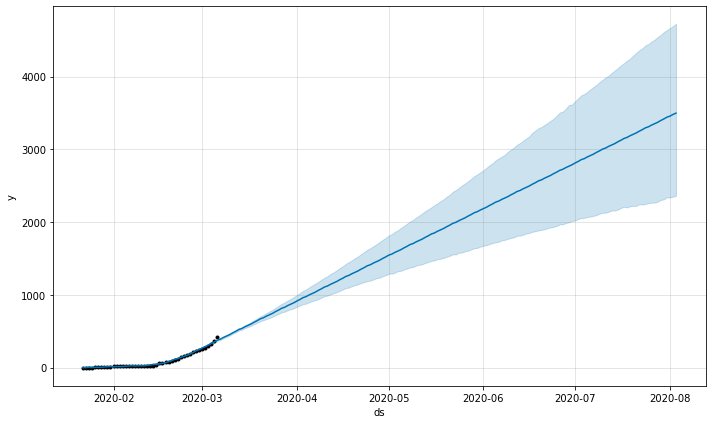

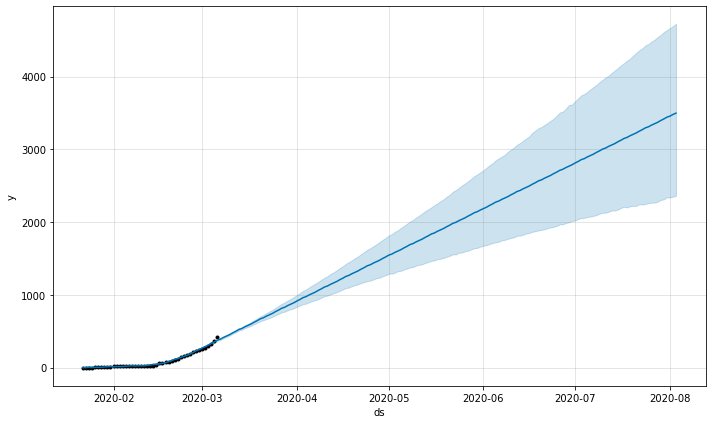

In [44]:
model.plot(forecast)

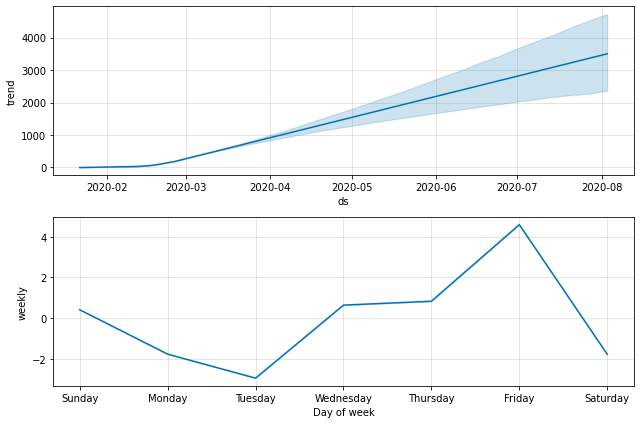

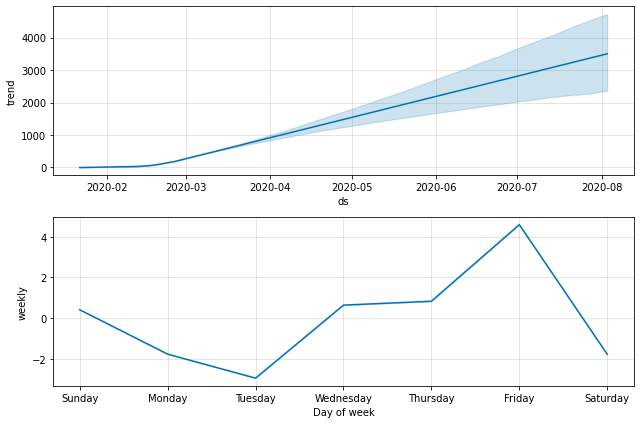

In [45]:
model.plot_components(forecast)

In [46]:
#Evaluate
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-01-22,-0.602558,-12.337376,10.621427,2.0
2020-01-23,1.099402,-10.047021,11.445070,2.0
2020-01-24,6.370199,-4.918974,17.675690,2.0
2020-01-25,1.516751,-8.753883,12.615592,2.0
2020-01-26,5.216801,-5.246721,15.962733,4.0


In [47]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

for err_name, err_value in calculate_forecast_errors(cmp_df, pred_size).items():
    print(err_name, err_value)

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df)
df_p.head()

MAPE nan
MAE nan


KeyError: ignored

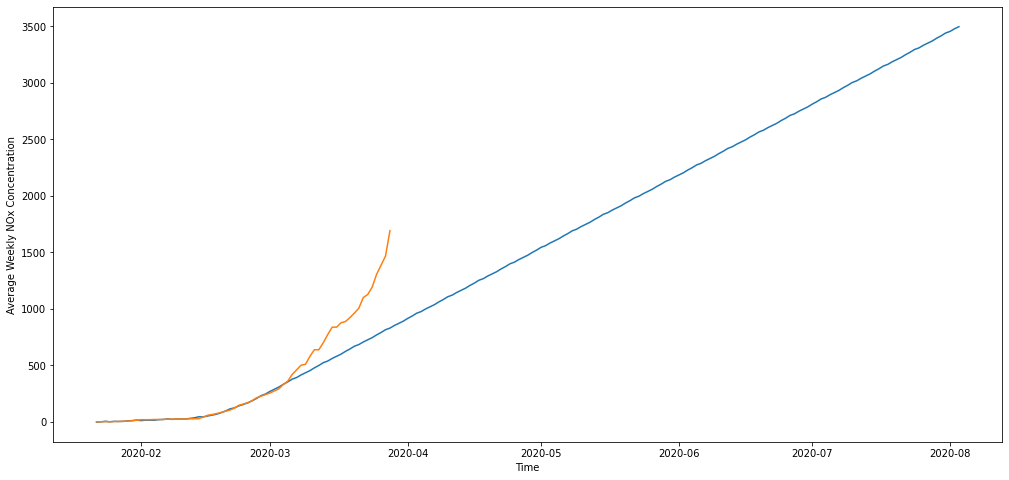

In [48]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
# plt.plot(cmp_df['yhat_lower'])
# plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()